In [48]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from matplotlib import gridspec
import optuna
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', sep=',', header=0)

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.select_dtypes(include=['int', 'float']).columns, len(df.select_dtypes(include=['int', 'float']).columns), df.select_dtypes(exclude=['int', 'float']).columns, len(df.select_dtypes(exclude=['int', 'float']).columns)

(Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
        'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
       dtype='object'),
 8,
 Index(['type', 'nameOrig', 'nameDest'], dtype='object'),
 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df['isFraud'] = df['isFraud'].astype('object')

In [8]:
df.describe(include=[int, float])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [9]:
df.describe(include=[object])

,type,nameOrig,nameDest,isFraud
count,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2
top,CASH_OUT,C1902386530,C1286084959,0
freq,2237500,3,113,6354407


In [10]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

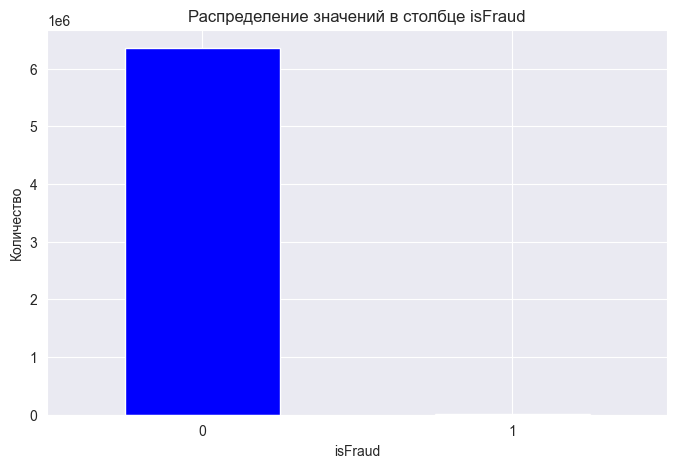

In [11]:
fraud_counts = df['isFraud'].value_counts()
fraud_counts.plot(kind='bar', color=['blue', 'red'], figsize=(8, 5))

plt.title('Распределение значений в столбце isFraud')
plt.xlabel('isFraud')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

In [12]:
fraud_counts_percent = df['isFraud'].value_counts(normalize=True) * 100  
fraud_counts_percent

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

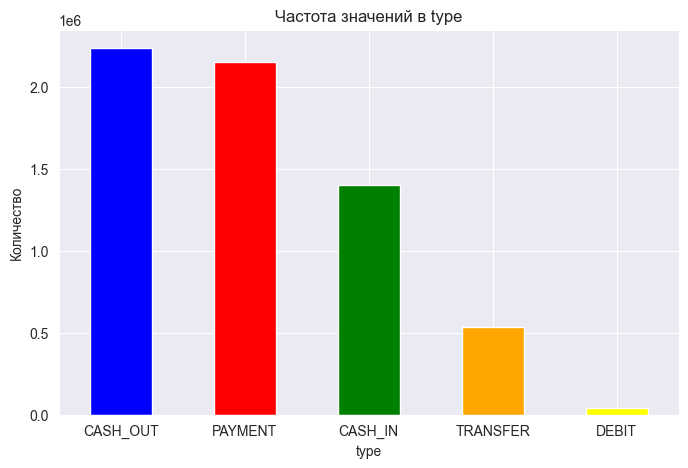

In [13]:
fraud_counts = df['type'].value_counts()
fraud_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange', 'yellow'], figsize=(8, 5))

plt.title('Частота значений в type')
plt.xlabel('type')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

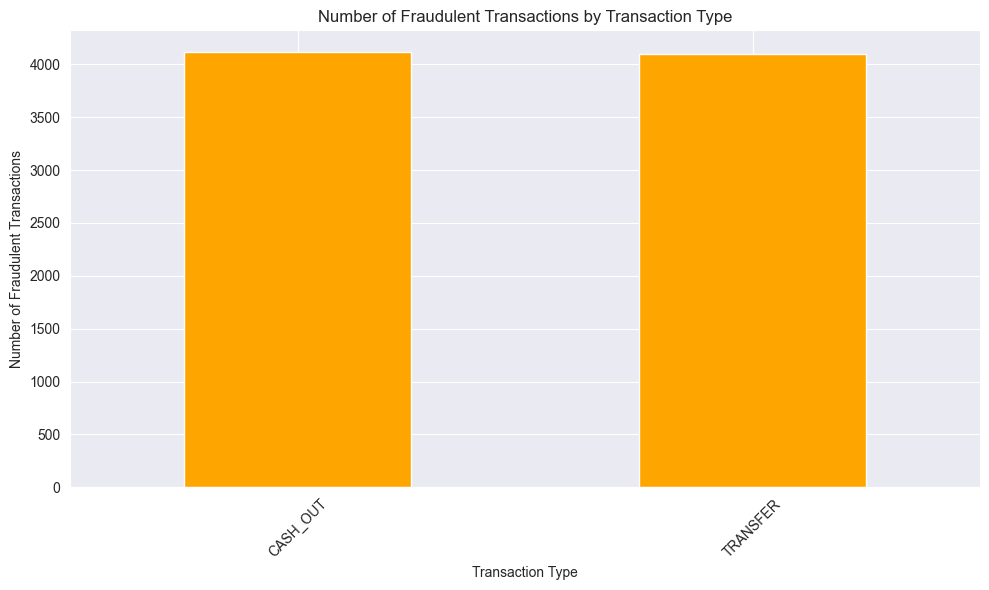

In [14]:
fraud_counts = df[df['isFraud'] == 1].groupby('type').size()

fraud_counts.plot(kind='bar', figsize=(10, 6), color='orange')

plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Number of Fraudulent Transactions by Transaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
data = df.drop_duplicates()
data = data.loc[data['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new data now has ', len(data), ' transactions.')

The new data now has  2770409  transactions.


In [16]:
data.shape

(2770409, 11)

In [17]:
print('Number of transactions where the transaction amount is negative: ' +
      str(sum(data['amount'] < 0)))


Number of transactions where the transaction amount is negative: 0


In [18]:
print('Number of transactions where the transaction amount is negative: ' +
      str(sum(data['amount'] == 0)))


Number of transactions where the transaction amount is negative: 16


In [19]:
data = data.loc[data['amount'] > 0,:]

In [20]:
originator_zero_balance_percentage = (data['oldbalanceOrg'] == 0).mean() * 100

destination_zero_balance_percentage = (data['newbalanceDest'] == 0).mean() * 100

print(f"Percentage of transactions where originator's initial balance is 0: {originator_zero_balance_percentage:.2f}%")
print(f"Percentage of transactions where destination's final balance is 0: {destination_zero_balance_percentage:.2f}%")

Percentage of transactions where originator's initial balance is 0: 47.23%
Percentage of transactions where destination's final balance is 0: 0.60%


In [21]:
data['sender_balance_correct'] = data['newbalanceOrig'] == (data['oldbalanceOrg'] - data['amount'])

data['receiver_balance_correct'] = data['newbalanceDest'] == (data['oldbalanceDest'] + data['amount'])

total_transactions = len(data)
incorrect_sender_balances = len(data[~data['sender_balance_correct']])
incorrect_receiver_balances = len(data[~data['receiver_balance_correct']])

percent_incorrect_sender = (incorrect_sender_balances / total_transactions) * 100
percent_incorrect_receiver = (incorrect_receiver_balances / total_transactions) * 100

print(f"% transactions where originator balances are not accurately captured: {percent_incorrect_sender:.2f}")
print(f"% transactions where destination balances are not accurately captured: {percent_incorrect_receiver:.2f}")  

% transactions where originator balances are not accurately captured: 93.72
% transactions where destination balances are not accurately captured: 42.09


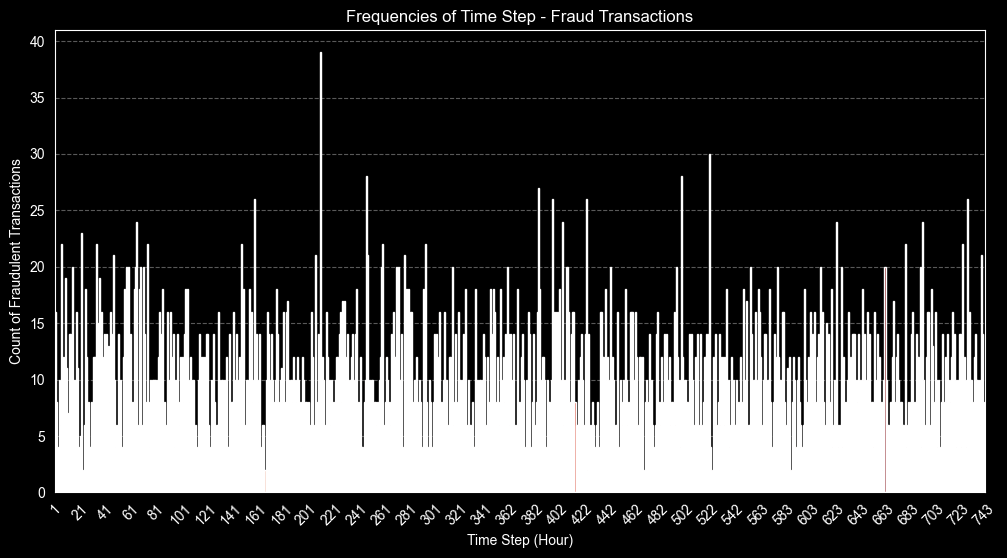

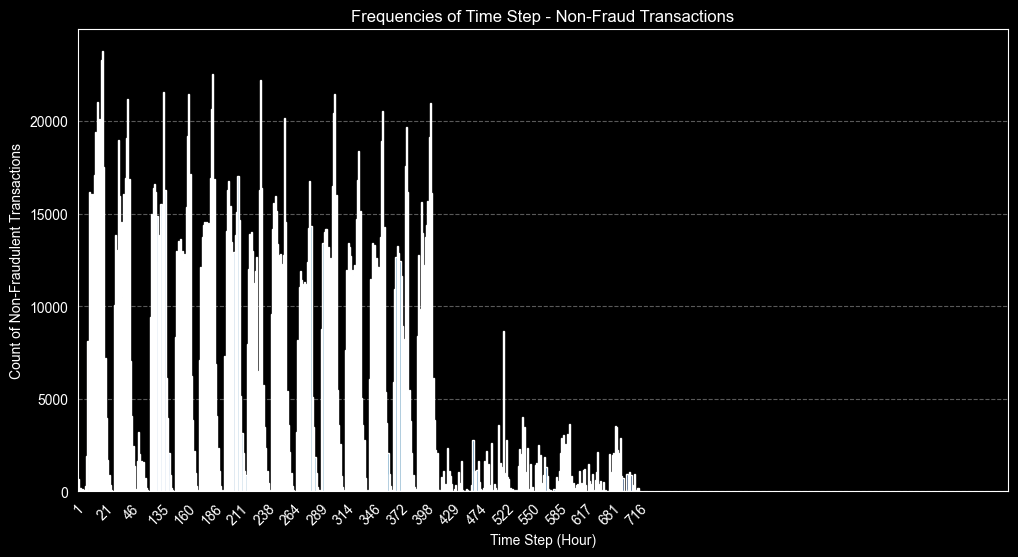

In [22]:
fraud_data = data[data['isFraud'] == 1]
non_fraud_data = data[data['isFraud'] == 0]

fraud_counts = fraud_data.groupby('step').size().reset_index(name='count')
non_fraud_counts = non_fraud_data.groupby('step').size().reset_index(name='count')

fraud_palette = sns.color_palette("Reds", len(fraud_counts))
non_fraud_palette = sns.color_palette("Blues", len(non_fraud_counts))

plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_counts, x='step', y='count', palette=fraud_palette)
plt.title('Frequencies of Time Step - Fraud Transactions', color='white')
plt.xlabel('Time Step (Hour)', color='white')
plt.ylabel('Count of Fraudulent Transactions', color='white')

x_ticks = range(0, fraud_counts['step'].max() + 1, 20)
plt.xticks(ticks=x_ticks, color='white', rotation=45)

plt.yticks(color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=non_fraud_counts, x='step', y='count', palette=non_fraud_palette)
plt.title('Frequencies of Time Step - Non-Fraud Transactions', color='white')
plt.xlabel('Time Step (Hour)', color='white')
plt.ylabel('Count of Non-Fraudulent Transactions', color='white')

x_ticks = range(0, non_fraud_counts['step'].max() + 1, 20)  
plt.xticks(ticks=x_ticks, color='white', rotation=45)

plt.yticks(color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')
plt.show()

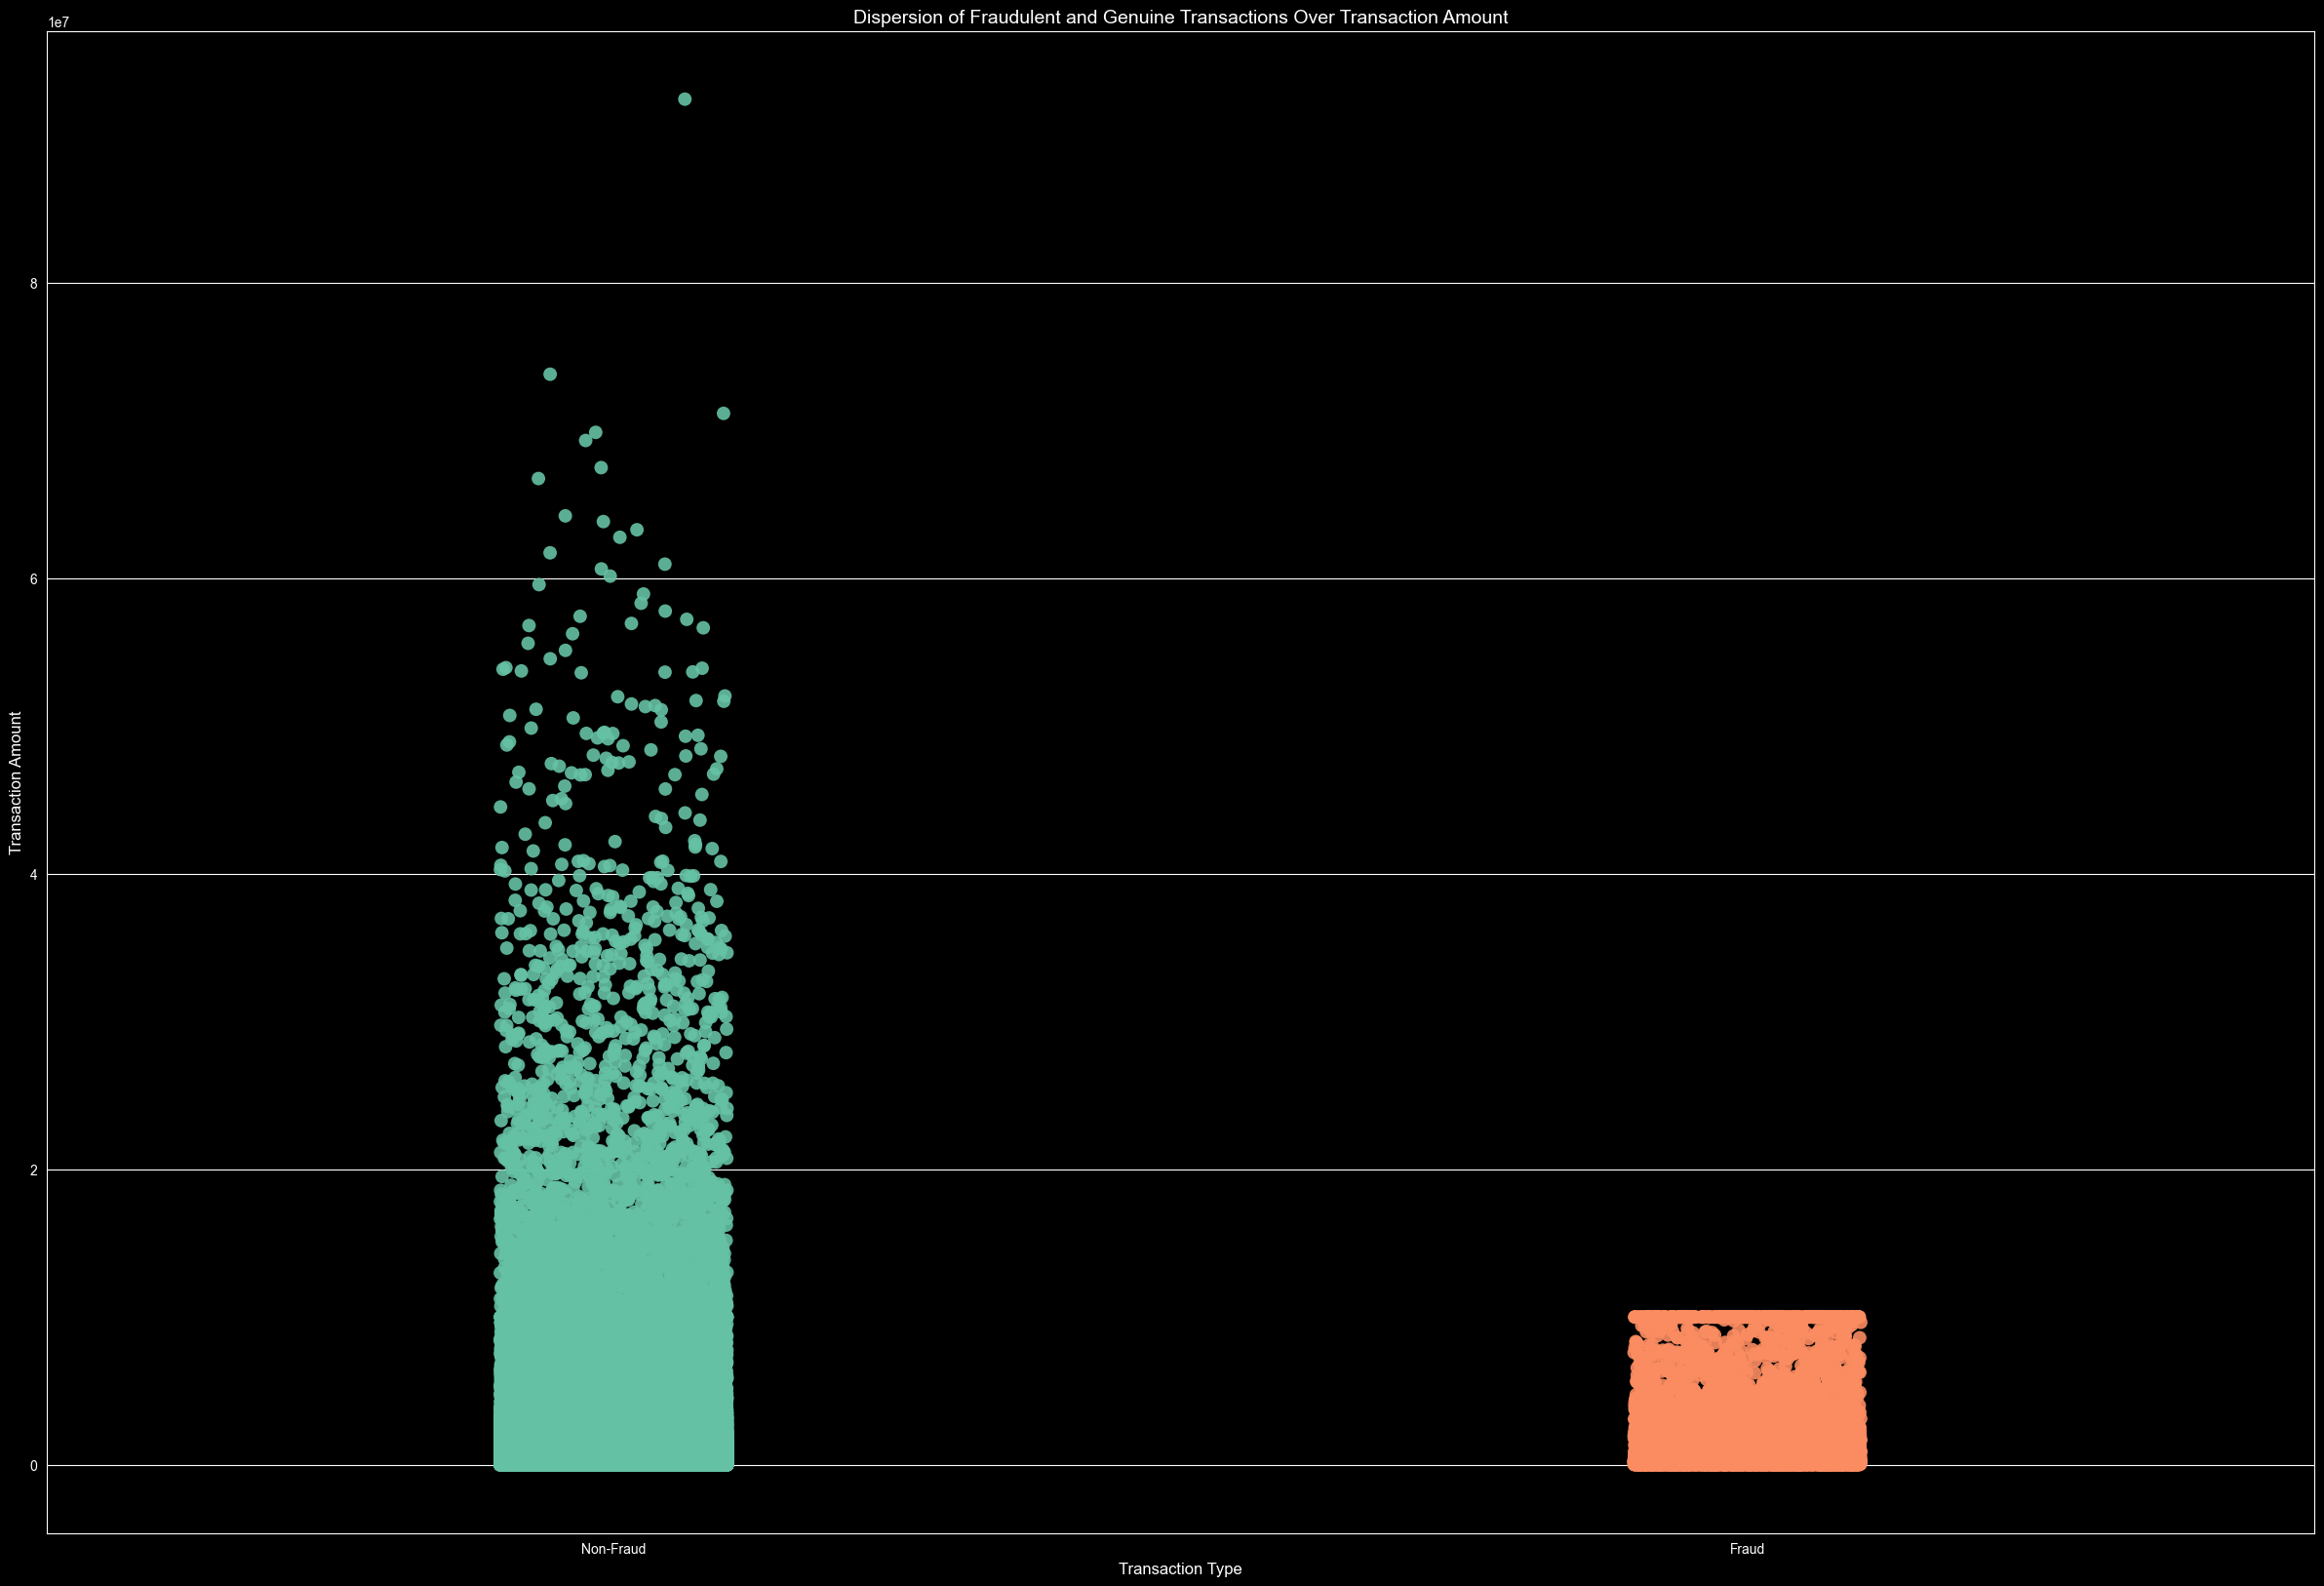

In [23]:
plt.figure(figsize=(30, 20))
sns.stripplot(x='isFraud', y='amount', data=data, jitter=True, palette='Set2', alpha=0.9, size=10)

plt.title('Dispersion of Fraudulent and Genuine Transactions Over Transaction Amount', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

plt.show()

In [24]:
fraud_with_zero_balance = len(fraud_data[fraud_data['oldbalanceOrg'] == 0]) / len(fraud_data) * 100
genuine_with_zero_balance = len(non_fraud_data[non_fraud_data['oldbalanceOrg'] == 0]) / len(non_fraud_data) * 100

print(f"% of fraudulent transactions where initial balance of originator is 0: {fraud_with_zero_balance:.2f}%")
print(f"% of genuine transactions where initial balance of originator is 0: {genuine_with_zero_balance:.2f}%")  

% of fraudulent transactions where initial balance of originator is 0: 0.30%
% of genuine transactions where initial balance of originator is 0: 47.37%


In [25]:
data['origBalance_inacc'] = (data['oldbalanceOrg'] - data['amount']) - data['newbalanceOrig']
data['destBalance_inacc'] = (data['oldbalanceDest'] + data['amount']) - data['newbalanceDest']

In [26]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sender_balance_correct,receiver_balance_correct,origBalance_inacc,destBalance_inacc
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,True,False,0.00,1.810000e+02
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,True,False,0.00,2.136300e+04
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0,False,False,-213808.94,1.827035e+05
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,False,False,-214605.30,2.377353e+05
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,False,False,-300850.89,-2.401220e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,True,True,0.00,0.000000e+00
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,True,False,0.00,6.311409e+06
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,True,False,0.00,1.000000e-02
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,True,False,0.00,8.500025e+05


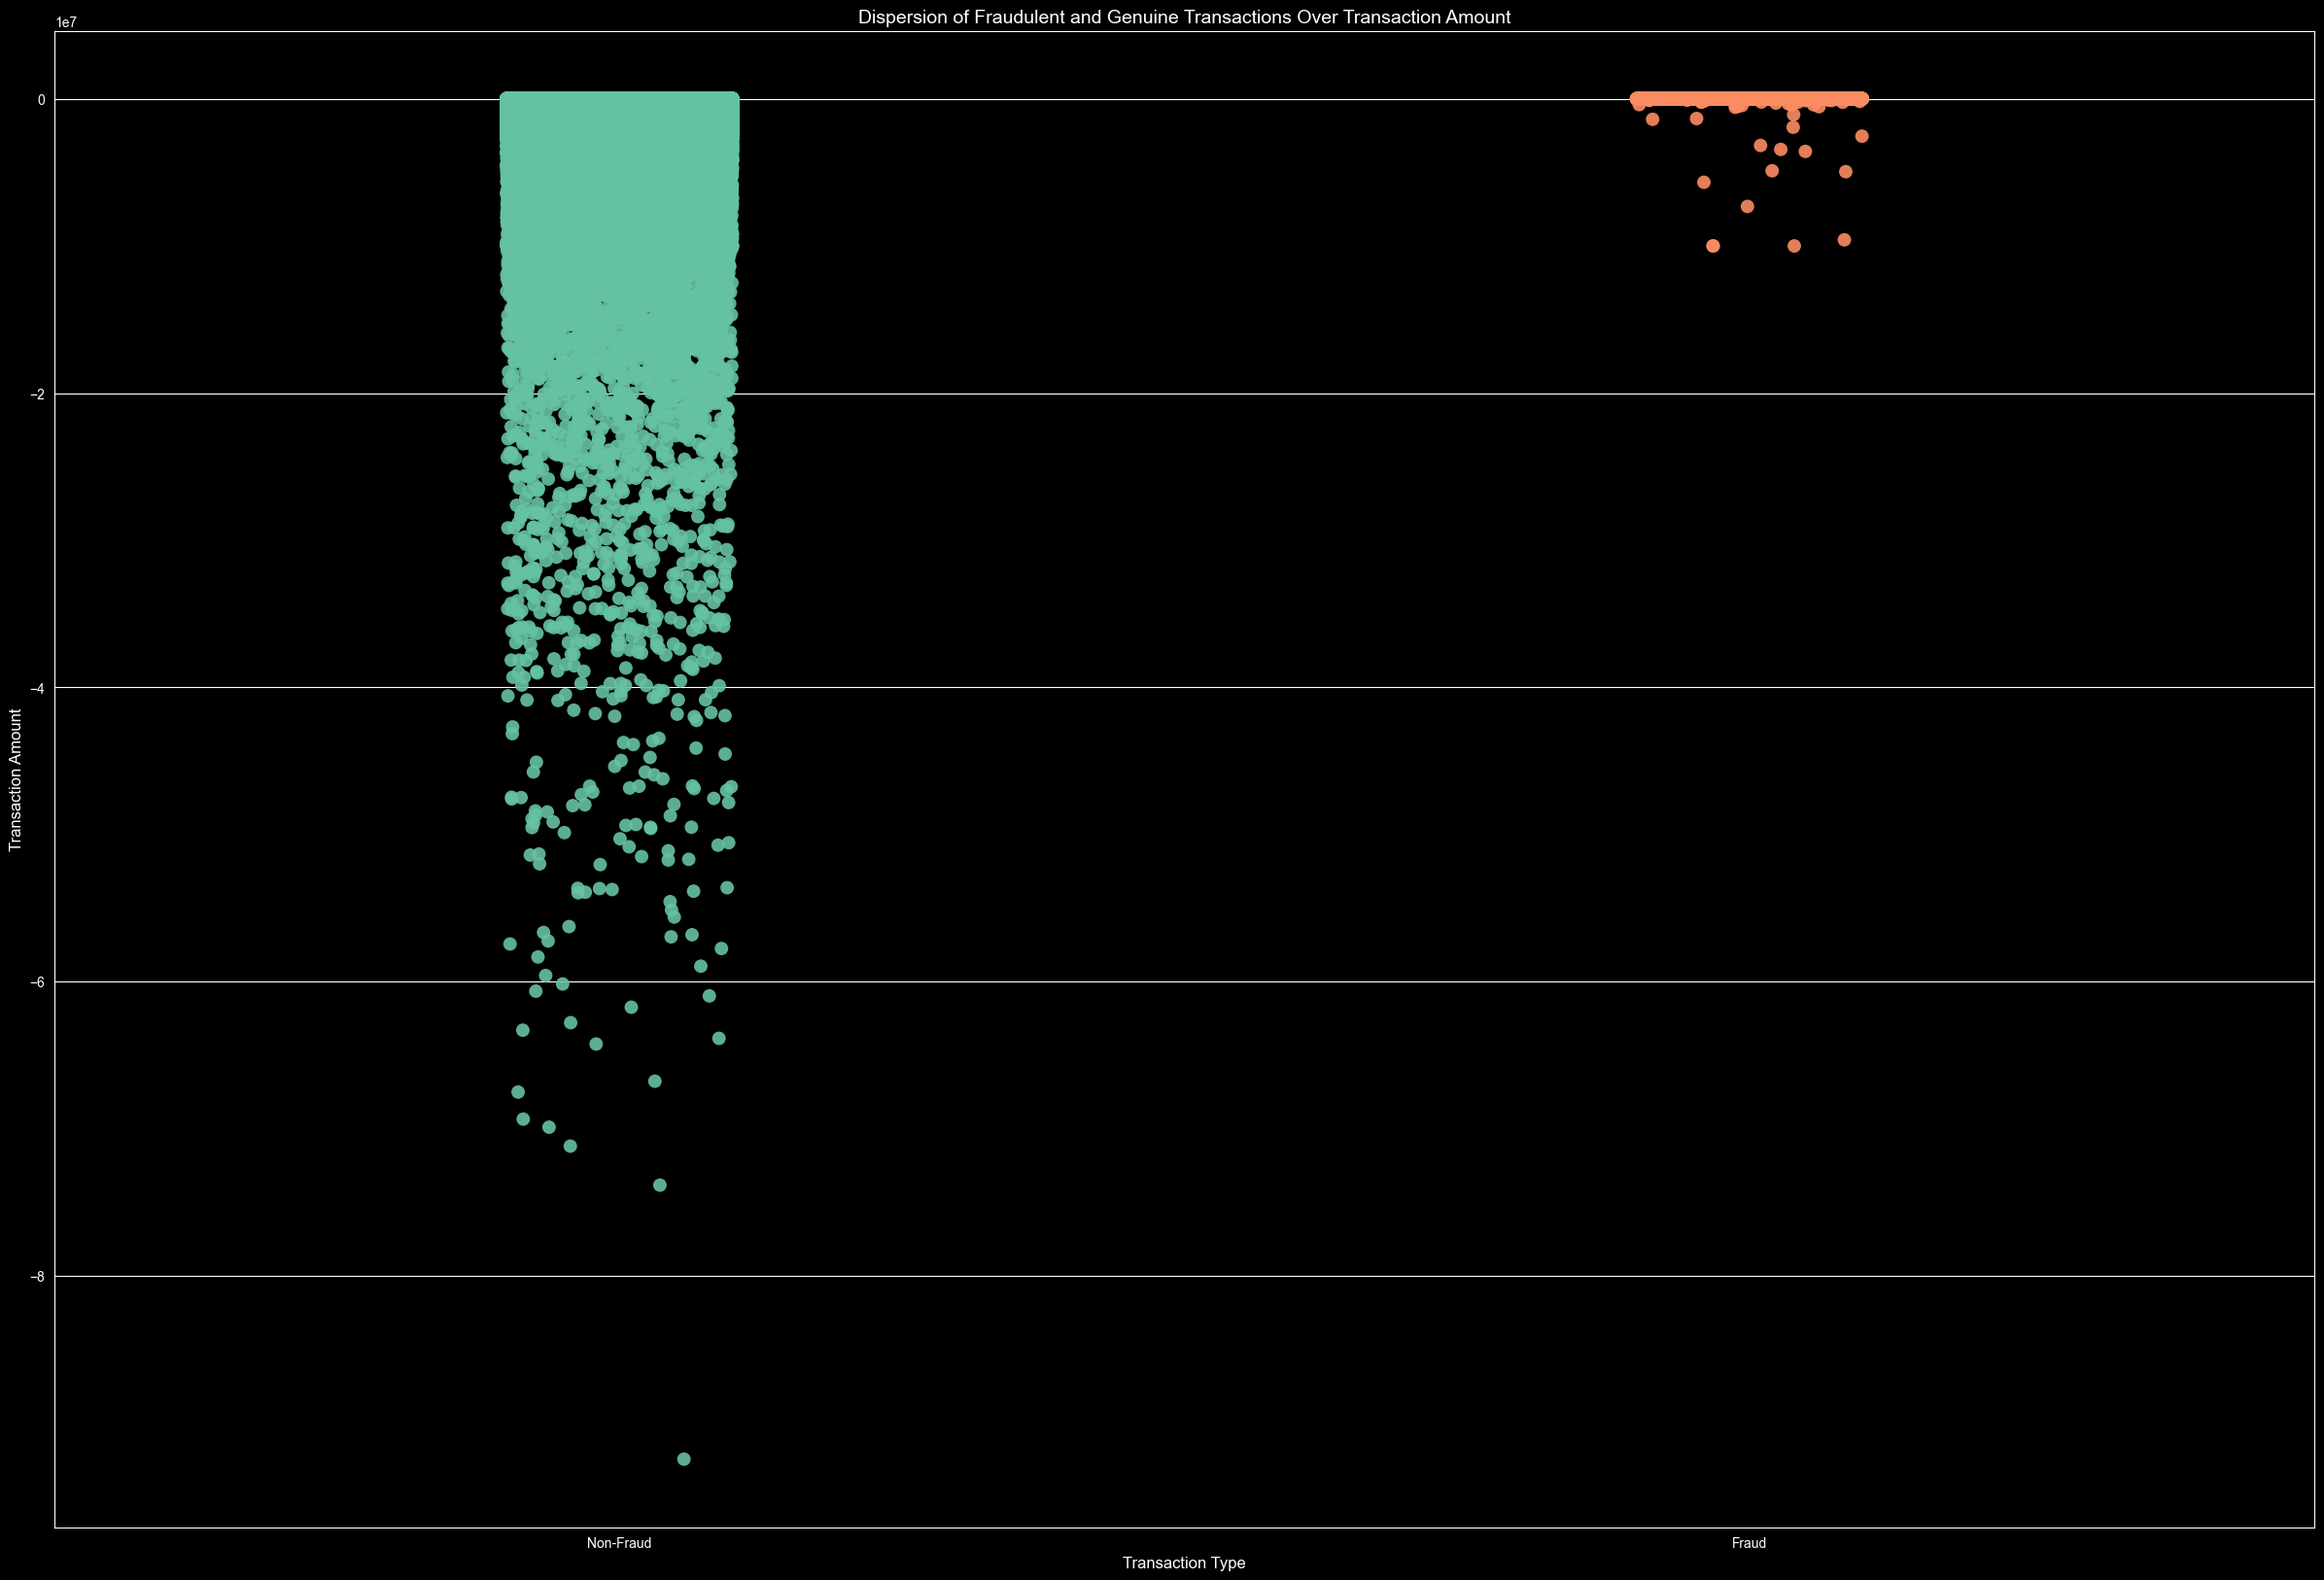

In [27]:
plt.figure(figsize=(30, 20))
sns.stripplot(x='isFraud', y='origBalance_inacc', data=data, jitter=True, palette='Set2', alpha=0.9, size=10)

plt.title('Dispersion of Fraudulent and Genuine Transactions Over Transaction Amount', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

plt.show()

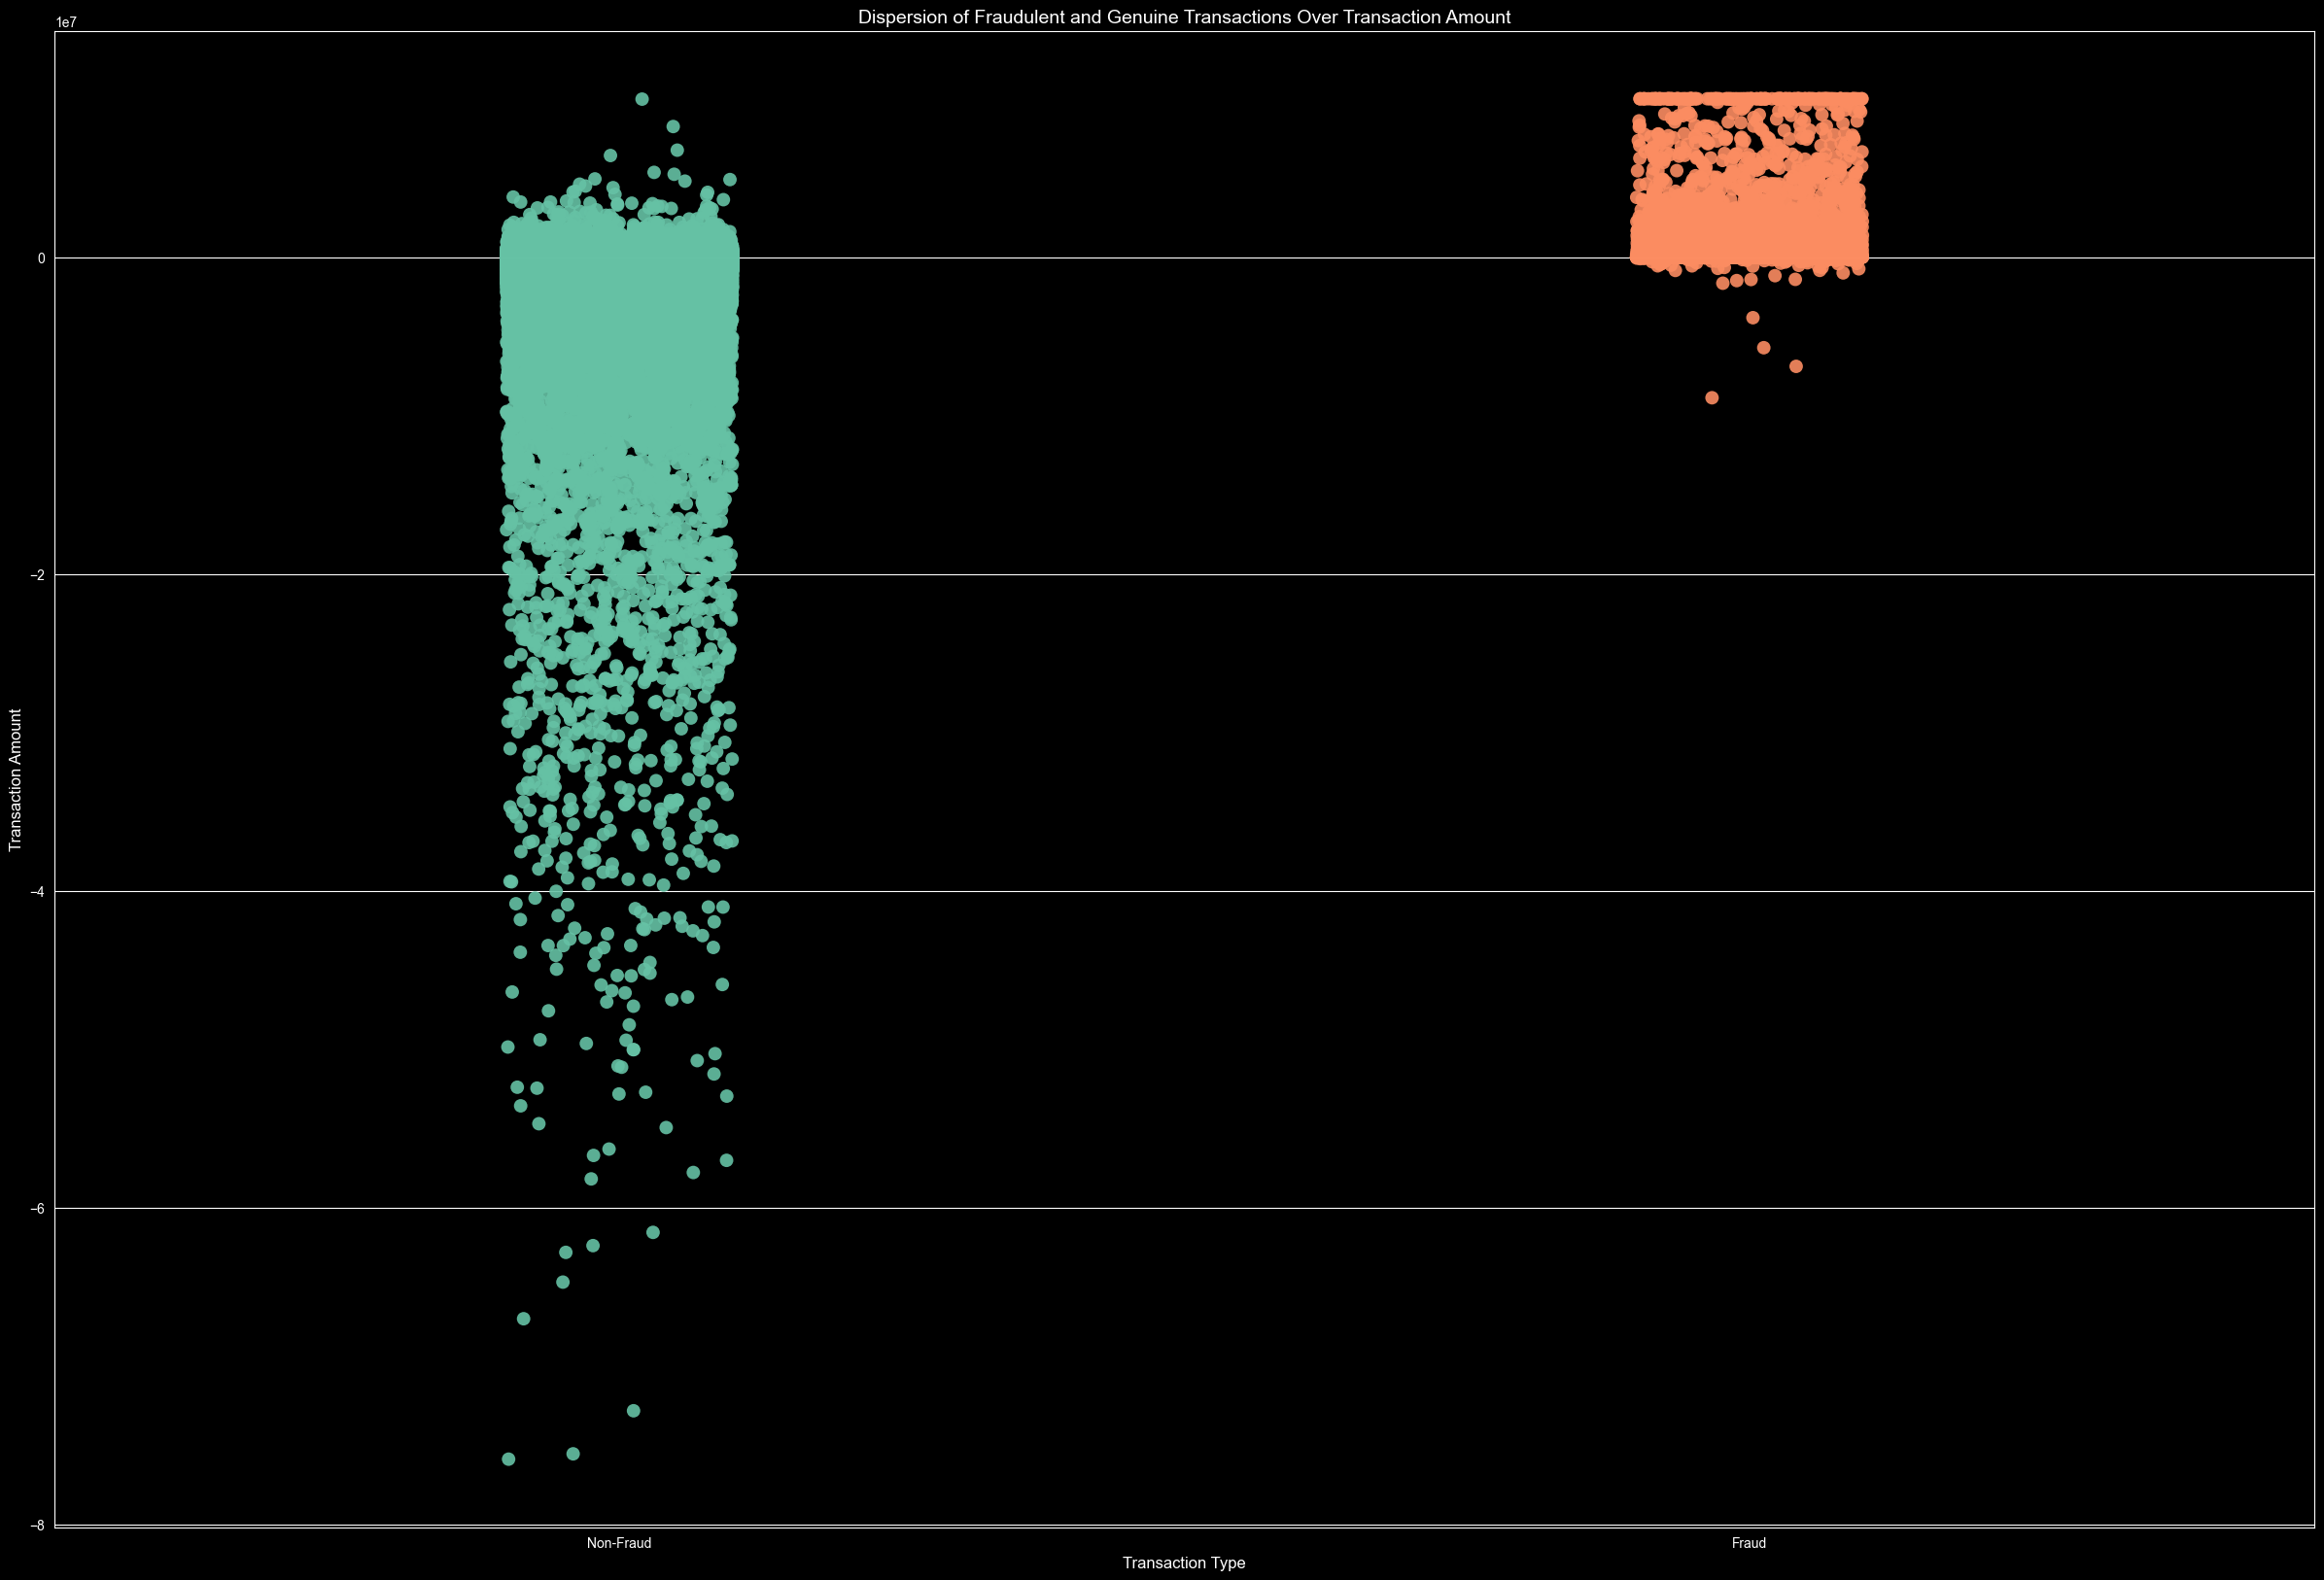

In [28]:
plt.figure(figsize=(30, 20))
sns.stripplot(x='isFraud', y='destBalance_inacc', data=data, jitter=True, palette='Set2', alpha=0.9, size=10)

plt.title('Dispersion of Fraudulent and Genuine Transactions Over Transaction Amount', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

plt.show()

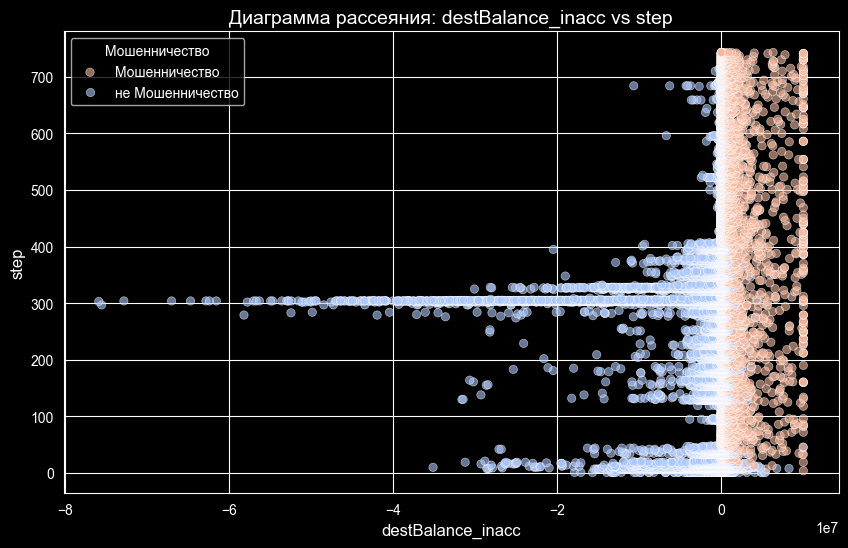

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='destBalance_inacc', y='step', hue='isFraud', alpha=0.6, palette='coolwarm')

plt.title('Диаграмма рассеяния: destBalance_inacc vs step', fontsize=14)
plt.xlabel('destBalance_inacc', fontsize=12)
plt.ylabel('step', fontsize=12)
plt.legend(title='Мошенничество', labels=['Мошенничество', 'не Мошенничество'])
plt.grid(True)

plt.show()  

In [30]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'sender_balance_correct', 'receiver_balance_correct',
       'origBalance_inacc', 'destBalance_inacc'],
      dtype='object')

In [31]:
data = data.drop(['nameOrig', 'nameDest'], axis=1)

In [32]:
data = data.drop(['sender_balance_correct', 'receiver_balance_correct'], axis=1)

In [33]:
data = pd.get_dummies(data, columns=['type'], prefix=['type'])

In [34]:
std_scaler = StandardScaler()
data_scaled = pd.DataFrame(std_scaler.fit_transform(data.loc[:,~data.columns.isin(['isFraud'])]))
data_scaled.columns = data.columns[:-1]
data_scaled['isFraud'] = data['isFraud'].values

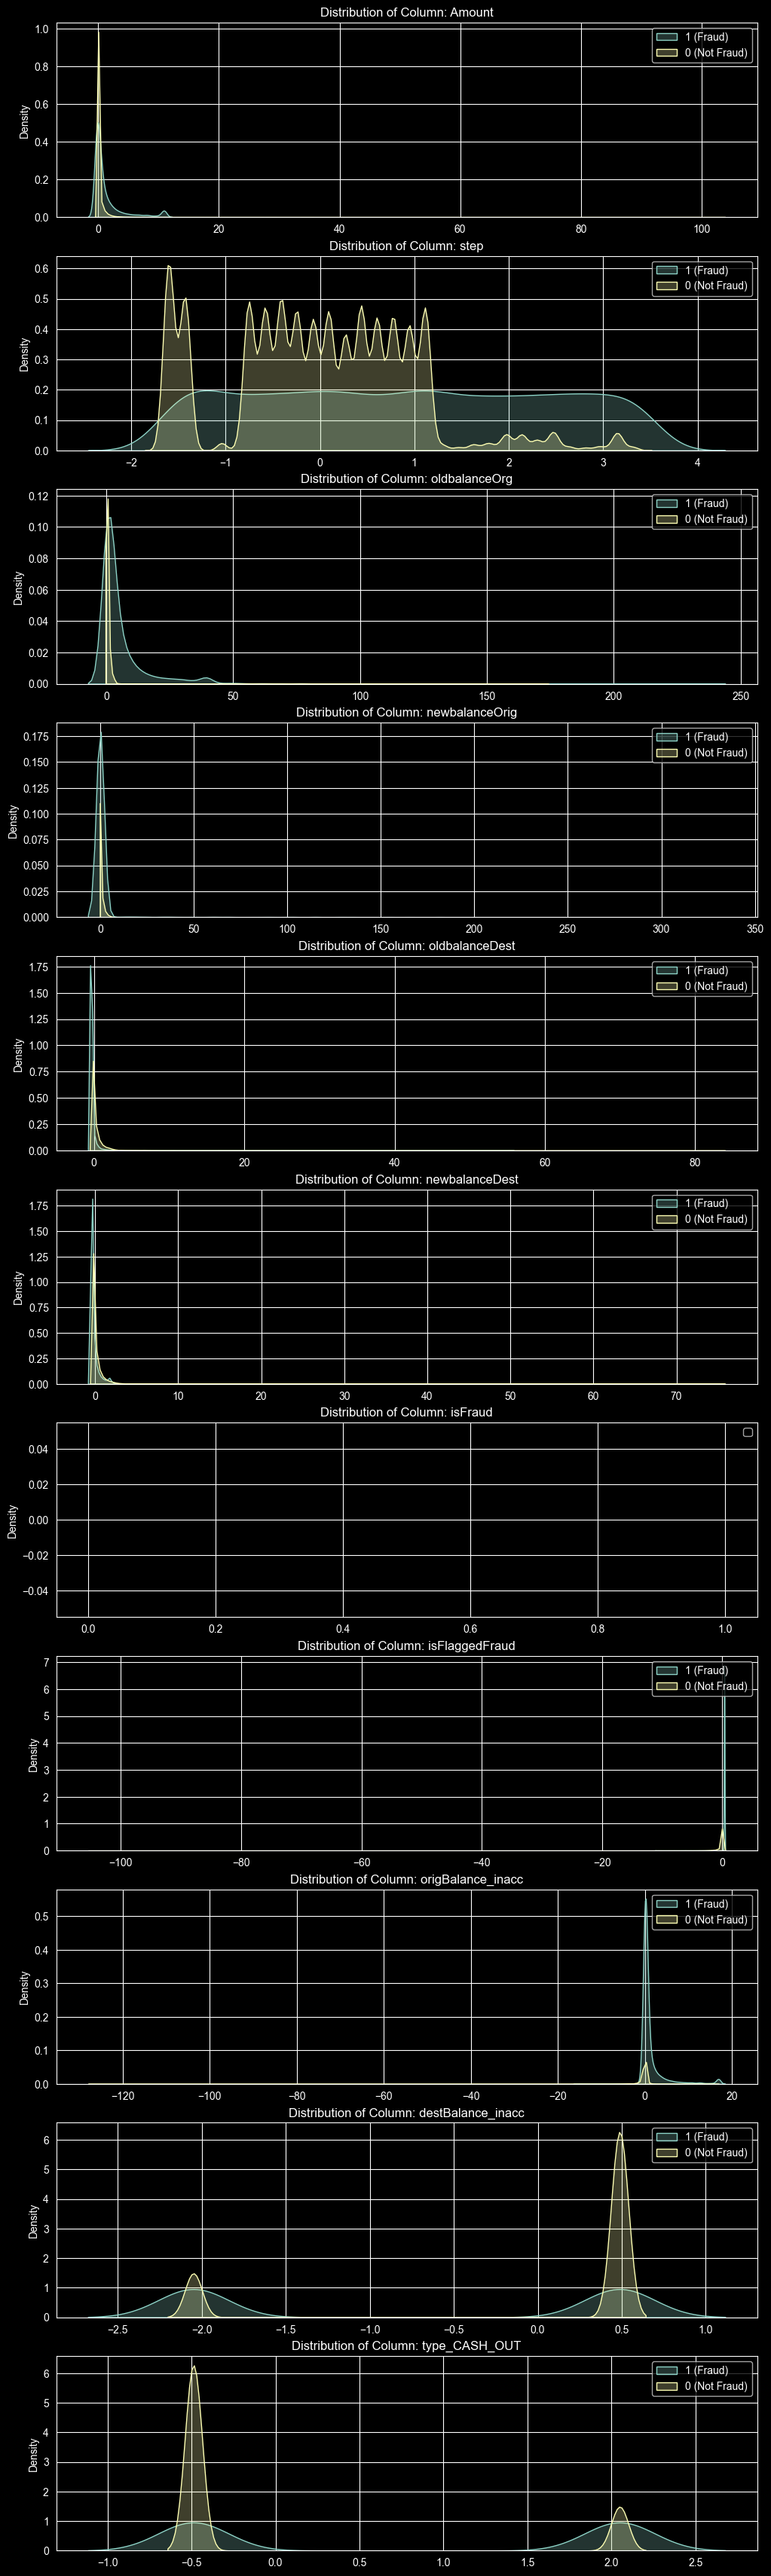

In [38]:
data_plot = data_scaled.copy()
amount = data_plot['amount']
data_plot.drop(labels=['amount'], axis=1, inplace=True)
data_plot.insert(0, 'Amount', amount)

# Plot the distributions of the features  
columns = data_plot.iloc[:, 0:30].columns
plt.figure(figsize=(12, 30 * 4))
grids = gridspec.GridSpec(30, 1)

for grid, index in enumerate(data_plot[columns]):
    ax = plt.subplot(grids[grid])
    sns.distplot(data_plot[index][data_plot['isFraud'] == 1], hist=False, kde_kws={"shade": True}, bins=50, label="1 (Fraud)")
    sns.distplot(data_plot[index][data_plot['isFraud'] == 0], hist=False, kde_kws={"shade": True}, bins=50, label="0 (Not Fraud)")
    ax.set_xlabel("")
    ax.set_title("Distribution of Column: " + str(index))
    ax.legend(loc="upper right")  # Add legend to each subplot  

plt.show()

In [35]:
data_scaled['isFraud'].value_counts()

isFraud
0    2762196
1       8197
Name: count, dtype: int64

In [36]:
data_scaled

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origBalance_inacc,destBalance_inacc,type_CASH_OUT
0,-1.701817,-0.357468,-0.188848,-0.106389,-0.403155,-0.438260,1,0.326720,0.048575,-2.049054,2.049054
1,-1.701817,-0.357468,-0.188848,-0.106389,-0.398142,-0.438260,1,0.326720,0.084266,0.488030,-0.488030
2,-1.701817,-0.099577,-0.128591,-0.106389,-0.401952,-0.427246,0,0.082458,0.356121,0.488030,-0.488030
3,-1.701817,-0.115148,-0.186763,-0.106389,-0.397848,-0.438260,0,0.081548,0.448848,-2.049054,2.049054
4,-1.701817,-0.006592,-0.146457,-0.106389,-0.401672,0.143133,0,-0.016981,-3.997723,-2.049054,2.049054
...,...,...,...,...,...,...,...,...,...,...,...
2770388,3.537664,0.024943,1.161993,-0.106389,-0.403155,-0.365632,1,0.326720,0.048270,0.488030,-0.488030
2770389,3.537664,6.751439,24.922894,-0.106389,-0.403155,-0.438260,1,0.326720,10.682829,-2.049054,2.049054
2770390,3.537664,6.751439,24.922894,-0.106389,-0.386947,0.925841,1,0.326720,0.048270,0.488030,-0.488030
2770391,3.537664,0.599763,3.192506,-0.106389,-0.403155,-0.438260,1,0.326720,1.480502,-2.049054,2.049054


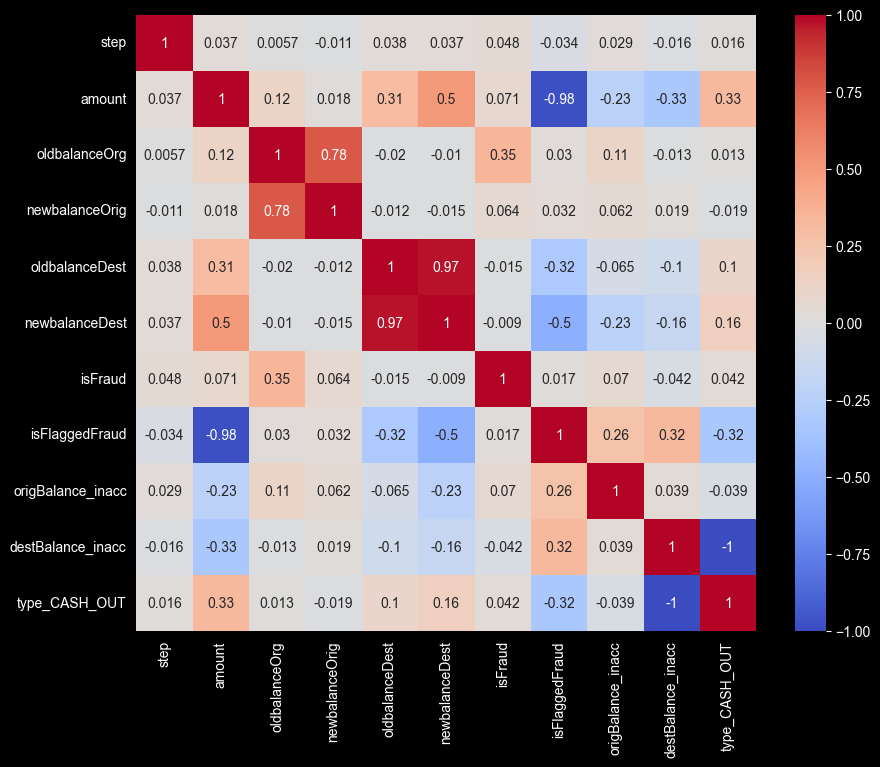

In [37]:
correlation_matrix = data_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [38]:
data_scaled.drop(['oldbalanceDest', 'destBalance_inacc'], axis=1, inplace=True)

In [39]:
X = data_scaled.loc[:, data_scaled.columns != 'isFraud']
y = data_scaled.loc[:, data_scaled.columns == 'isFraud']
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X,y,test_size = 0.3, random_state = 0)
label_encoder = LabelEncoder()
y_train_original = label_encoder.fit_transform(y_train_original.values.ravel())
y_test_original = label_encoder.fit_transform(y_test_original.values.ravel())

In [40]:
train_imbalance = (sum(y_train_original == 1) / len(y_train_original)) * 100
test_imbalance = (sum(y_test_original == 1) / len(y_test_original)) * 100

print(f"Class imbalance in train dataset: {train_imbalance:.3f}%")
print(f"Class imbalance in test dataset: {test_imbalance:.3f}%")

Class imbalance in train dataset: 0.296%
Class imbalance in test dataset: 0.296%


In [41]:
scr = 'recall'
accuracy_dict = {}
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()

In [42]:
skf = StratifiedKFold(5)

## Лог. регрессия

Train Metrics:
Precision: 0.90
Recall: 0.49

Test Metrics:
Precision: 0.90
Recall: 0.50


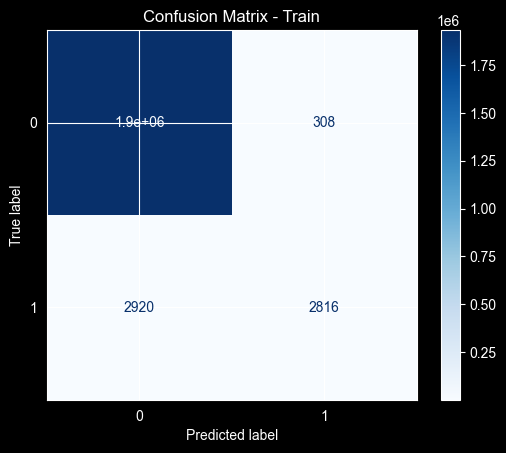

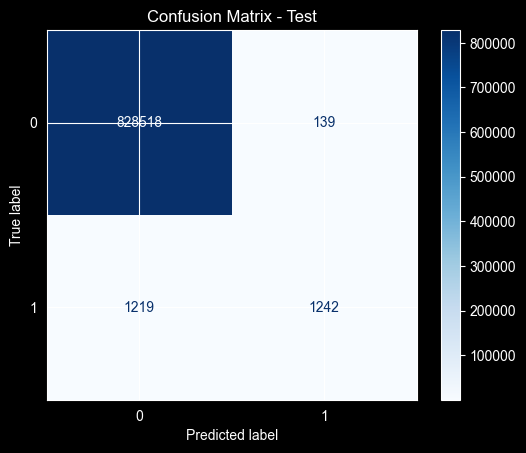

In [46]:
model_lr.fit(X_train_original, y_train_original)

y_train_pred = model_lr.predict(X_train_original)
y_test_pred = model_lr.predict(X_test_original)

train_precision = precision_score(y_train_original, y_train_pred)
train_recall = recall_score(y_train_original, y_train_pred)

test_precision = precision_score(y_test_original, y_test_pred)
test_recall = recall_score(y_test_original, y_test_pred)

print("Train Metrics:")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")

print("\nTest Metrics:")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")

train_conf_matrix = confusion_matrix(y_train_original, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=model_lr.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")
plt.show()

test_conf_matrix = confusion_matrix(y_test_original, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=model_lr.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test")
plt.show()

## Лог. регрессия с кросс-валидацией

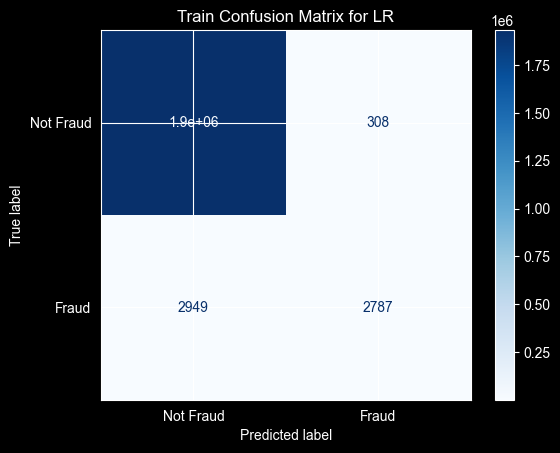

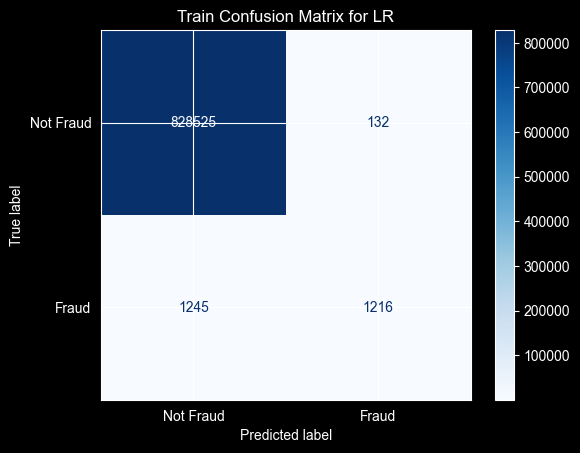

In [49]:
y_train_pred_lr = cross_val_predict(model_lr, X_train_original, y_train_original, cv=skf)

cm_lr = confusion_matrix(y_train_original, y_train_pred_lr)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Not Fraud', 'Fraud'])
disp_lr.plot(cmap='Blues')
plt.title('Train Confusion Matrix for LR')

y_test_pred_lr = cross_val_predict(model_lr, X_test_original, y_test_original, cv=skf)

cm_lr = confusion_matrix(y_test_original, y_test_pred_lr)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Not Fraud', 'Fraud'])
disp_lr.plot(cmap='Blues')
plt.title('Train Confusion Matrix for LR')

plt.show()

## Поиск оптимальных гиперпараметров (байесовская оптимизация)

In [46]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  
    penalty = 'l2' if solver in ['lbfgs', 'saga'] else trial.suggest_categorical('penalty', ['l1', 'l2'])

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=50, random_state=42))
    ])

    scorer = make_scorer(recall_score, average='macro')
    scores = cross_val_score(pipeline, X_train_original, y_train_original, cv=5, scoring=scorer)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)

best_params = study.best_params
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=best_params['C'],
        solver=best_params['solver'],
        penalty=best_params.get('penalty', 'l2'),
        max_iter=50,
        random_state=42
    ))
])

final_model.fit(X_train_original, y_train_original)

y_pred = final_model.predict(X_test_original)
recall = recall_score(y_test_original, y_pred, average='macro')
print("Test recall:", recall)

[I 2025-02-03 14:22:12,669] A new study created in memory with name: no-name-d009470d-1d69-4f5a-a3a5-c6aeda221a08
[I 2025-02-03 14:22:18,016] Trial 0 finished with value: 0.7447762392705172 and parameters: {'C': 4.2034876543336255, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7447762392705172.
[I 2025-02-03 14:24:14,946] Trial 1 finished with value: 0.6784007013871672 and parameters: {'C': 0.007836764628077204, 'solver': 'saga'}. Best is trial 0 with value: 0.7447762392705172.
[I 2025-02-03 14:26:10,451] Trial 2 finished with value: 0.6135728000366855 and parameters: {'C': 0.00020342001174645982, 'solver': 'saga'}. Best is trial 0 with value: 0.7447762392705172.
[I 2025-02-03 14:26:29,491] Trial 3 finished with value: 0.7416415860443939 and parameters: {'C': 0.4306550962110106, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 0 with value: 0.7447762392705172.
[W 2025-02-03 14:28:10,816] Trial 4 failed with parameters: {'C': 0.007958582112851274, 'solver': 'saga'} because of 

KeyboardInterrupt: 

In [57]:
models = {
    'Logistic Regression' : (LogisticRegression(max_iter=50, random_state=42), {
    # 'max_iter': [50, 100, 150],
    'C': [0.01, 0.1, 1, 10],
    # 'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear'],
    # 'dual': [True, False],
    # 'tol': [1e-5, 1e-5, 1e-4, 1e-3, 1e-2],
    # 'fit_intercept': [True, False], 
    # 'intercept_scaling': [0.5, 1, 5, 10, 100],
    # 'verbose': [0, 1, 2, 3, 5], 
    # 'warm_start': [True, False],
    })
}

best_models = {}
for name, (model, params) in models.items():
    print(f"Поиск оптимальных гиперпараметров для {name}...")
    if name in ['XGBoost', 'Gradient Boosting', 'AdaBoost', 'Random Forest', 'MLP']:
        search = RandomizedSearchCV(model, params, n_iter=100, cv=5, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1, random_state=42)
    else:
        search = GridSearchCV(model, params, cv=5, scoring='recall')

    search.fit(X_train_original, y_train_original)
    best_models[name] = search.best_estimator_
    print(f"Лучшие гиперпараметры для {name}: {search.best_params_}")

results = {}
for name, model in best_models.items():
    print(f"\nОценка модели {name}:")
    y_pred = model.predict(X_test_original)

    y_prob_train = model.predict_proba(X_train_original)[:, 1]
    y_prob_test = model.predict_proba(X_test_original)[:, 1]

    recall = recall_score(y_test_original, y_pred)
    classification_rep = classification_report(y_test_original, y_pred)
    confusion_mat = confusion_matrix(y_test_original, y_pred)

    results[name] = {
        'Recall': recall,
        'Classification Report': classification_rep,
        'Confusion Matrix': confusion_mat
    }

    print("\nОтчет по классификации:")
    print(classification_rep)
    print("\nМатрица ошибок:")
    print(confusion_mat)


Оценка модели Logistic Regression:

Отчет по классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828657
           1       0.90      0.50      0.65      2461

    accuracy                           1.00    831118
   macro avg       0.95      0.75      0.82    831118
weighted avg       1.00      1.00      1.00    831118


Матрица ошибок:
[[828521    136]
 [  1223   1238]]


Train Metrics:
Precision: 0.90
Recall: 0.49

Test Metrics:
Precision: 0.90
Recall: 0.50


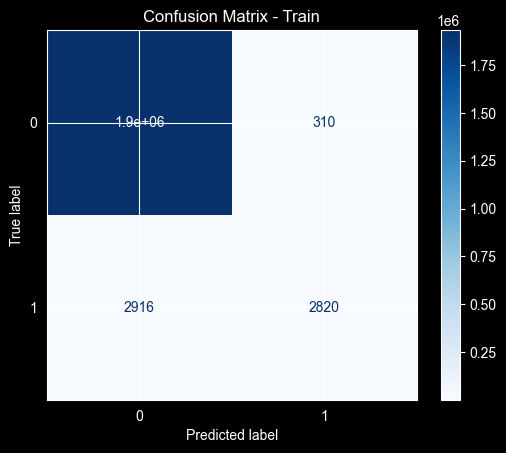

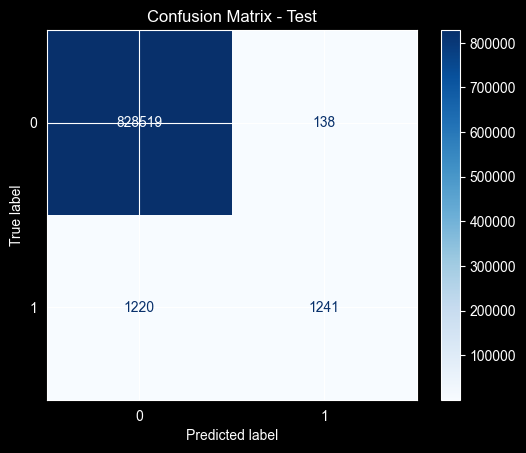

In [45]:
model_lr_best = LogisticRegression(C=1.6483809328076928, solver='lbfgs')

model_lr_best.fit(X_train_original, y_train_original)

y_train_pred = model_lr_best.predict(X_train_original)
y_test_pred = model_lr_best.predict(X_test_original)

train_precision = precision_score(y_train_original, y_train_pred)
train_recall = recall_score(y_train_original, y_train_pred)

test_precision = precision_score(y_test_original, y_test_pred)
test_recall = recall_score(y_test_original, y_test_pred)

print("Train Metrics:")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")

print("\nTest Metrics:")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")

train_conf_matrix = confusion_matrix(y_train_original, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=model_lr_best.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")
plt.show()

test_conf_matrix = confusion_matrix(y_test_original, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=model_lr_best.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test")
plt.show()

## Random Forest

Train Metrics:
Precision: 1.00
Recall: 1.00

Test Metrics:
Precision: 1.00
Recall: 1.00


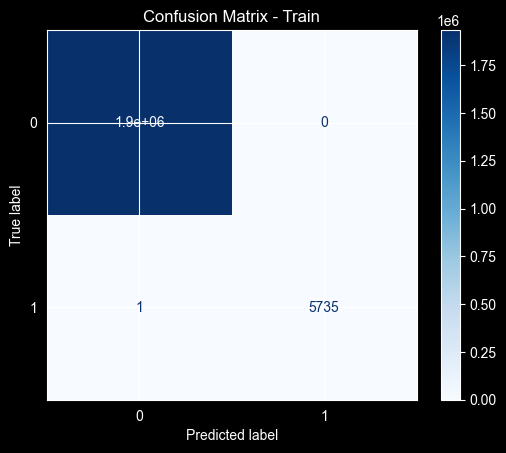

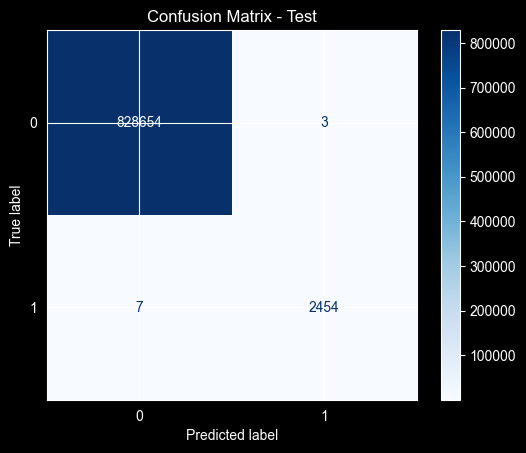

In [50]:
model_rf.fit(X_train_original, y_train_original)

y_train_pred = model_rf.predict(X_train_original)
y_test_pred = model_rf.predict(X_test_original)

train_precision = precision_score(y_train_original, y_train_pred)
train_recall = recall_score(y_train_original, y_train_pred)

test_precision = precision_score(y_test_original, y_test_pred)
test_recall = recall_score(y_test_original, y_test_pred)

print("Train Metrics:")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")

print("\nTest Metrics:")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")

train_conf_matrix = confusion_matrix(y_train_original, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=model_rf.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")
plt.show()

test_conf_matrix = confusion_matrix(y_test_original, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=model_rf.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test")
plt.show()